In [2]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [3]:
import pandas as pd 
import re
import json
import csv

from data_utils import getDF
from dataset_evaluation_utils import * 

from datetime import datetime, timezone

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import plotly.offline as py
# pd.options.plotting.backend = "plotly"
# py.init_notebook_mode() # graphs charts inline (IPython).

a4_dims = (11.7, 8.27)

# paths

In [4]:
dataset_folderpath = '../datasets/lastfm-1b/merged/'

dataset_name = 'LastFM1b'
dump_foldername ='lastfm1b_dump/'

# rule: what/which_data_set/sample_version/what/
images_path, output_path, heatmaps_path, diversity_graphpath, diversity_filepath = get_folderpaths(dump_foldername)

In [9]:
user_col, item_col, time_col, date_col = ['user_id', 'item_id', 'timestamp', 'date']

# dataset source

https://drive.google.com/drive/folders/1aXK8JSvOQMNjAplcp8TB2SBf-1uTn287

# examples

## lfm1b-tracks.inter

In [5]:
# ex_inter = pd.read_csv(dataset_folderpath+'lfm1b-tracks-example/lfm1b-tracks.inter', delimiter='\t')#, header=None)
# ex_inter.head()

,user_id:token,tracks_id:token,timestamp:float,num_repeat:float
0,31435741,4,1385212958,13
1,31435741,17,1381867823,23
2,31435741,19,1381867431,22
3,31435741,53,1370977938,54
4,31435741,86,1369853851,84


## lfm1b-tracks.item
tracks_id: the id of the tracks, and its type is token.\
name: the name of each track, and its type is token_seq.\
artists_id: the id of the artists to which the tracks belong, and its type is token.\

In [ ]:
# ex_item = pd.read_csv(dataset_folderpath+'lfm1b-tracks-example/lfm1b-tracks.item', delimiter='\t')#, header=None)
# ex_item.head()

## lfm1b-tracks.user
user_id: the id of the users, and its type is token.\
country: the country of the users, and its type is token.\
age: the age of the users, and its type is float.\
gender: the gender of the users, and its type is token.\
playcount: the number of playcount, and its type is float.\
registered_timestamp: the UNIX timestamp of users registering, and its type is float.\
novelty_artist_avg_month: the percentage of new artists listened to, averaged over time windows of 1 month, and its type is float.\
novelty_artist_avg_6months: the percentage of new artists listened to, averaged over time windows of 6 months, and its type is float.\
novelty_artist_avg_year: the percentage of new artists listened to, averaged over time windows of 1 year, and its type is float.\
mainstreaminess_avg_month: overlap between the user's listening history and an aggregate listening history of all users, averaged over time windows of 1 month, and its type is float.\
mainstreaminess_avg_6months: overlap between the user's listening history and an aggregate listening history of all users, averaged over time windows of 6 months, and its type is float.\
mainstreaminess_avg_year: overlap between the user's listening history and an aggregate listening history of all users, averaged over time windows of 1 year, and its type is float.\
mainstreaminess_global: overlap between the user's listening history and an aggregate listening history of all users, averaged over the entire period of the user's activity on Last.fm, and its type is float.\
cnt_listeningevents: total number of the user's listening events (playcounts) included in the dataset, and its type is float.\
cnt_distinct_tracks: number of unique tracks listened to by the user, and its type is float.\
cnt_distinct_artists: number of unique artists listened to by the user, and its type is float.\
cnt_listeningevents_per_week: average number of listening events per week, and its type is float.\
relative_le_per_weekday[1-7]: fraction of listening events for each weekday (starting on Monday) among all weekly plays, averaged over the user's entire listening history, and its type is float.\
relative le per hour[0-23]: fraction of listening events for each hour of the day (starting with the time span 0:00-0:59) among all 24 hours, averaged over the user's entire listening history, and its type is float.\

In [ ]:
# ex_user = pd.read_csv(dataset_folderpath+'lfm1b-tracks-example/lfm1b-tracks.user', delimiter='\t')#, header=None)
# ex_user.head()

## lfm1b-tracks.inter

In [ ]:
# tracks_inter = pd.read_csv(dataset_folderpath+'lfm1b-tracks/lfm1b-tracks.inter', delimiter='\t')#, iterator=True)
# tracks_inter.head()

# tracks_inter = pd.read_csv(dataset_folderpath+'lfm1b-tracks/lfm1b-tracks.inter', delimiter='\t', iterator=True)#, header=None)
# tracks_inter.get_chunk(100)

In [6]:
def load_interactions_within_period_to_dict(head:int, period:list, save_folder:str, save_filename:str, file_foldername:str):
    
    if save_folder: validate_folderpath(save_folder)


    time_period = [(period[0], '%Y-%m'), (period[1], '%Y-%m')]
    start_ym, end_ym = datetime.strptime(*time_period[0]), datetime.strptime(*time_period[1])

    user_col_idx = 0
    item_col_idx = 1
    time_col_idx = 2
    # repeat_col_idx = 3

    item_set, user_set = set(), set()

    # n_lines = 0
    inter_dict = {}

    with open(file_foldername, 'r') as file:
        # user_id:token tracks_id:token timestamp:float num_repeat:float
        file.readline()
        # print(file.readline())

        for i, line in enumerate(file):
            # print(line)
            # print(type(line))
            line_array = re.split('\t|\n', line) # leave the last '\n' column to make sure the file is read properly
            # print(line_array)

            # if (head is not None) and (i > head):
            if (head) and (i > head):
                break

            date = datetime.fromtimestamp(int(line_array[time_col_idx]), tz=timezone.utc)
            year_month = datetime.strptime( str(date.year)+'-'+str(date.month), '%Y-%m' )

            if i % 1000000 == 0:
                print(i, end=',')
                # print(str(i)+'-'+str(year_month))

            if start_ym <= year_month < end_ym:

                inter_dict[i] = [line_array[user_col_idx], line_array[item_col_idx], line_array[time_col_idx],year_month]

                item_set.add(line_array[item_col_idx])
                user_set.add(line_array[user_col_idx])

                # n_lines += 1

        # print(inter_dict)
    # if save_folder:
        # joblib.dump(inter_dict, save_folder+save_filename+'_dict.joblib')

    print('complete')
    print('done!')
    print('number of lines ',len(inter_dict))
    print('number of books ',len(item_set))
    print('number of users ',len(user_set))

    inter_df = pd.DataFrame.from_dict(inter_dict, orient='index',columns=['user_id', 'item_id', 'timestamp', 'date'])
    inter_df[['user_id', 'date']]\
            .groupby('date')\
                .count().sort_values(by=['date'], ascending=[True]).plot(title='how many interactions per month');

    if save_folder:
        inter_df.to_csv(save_folder+save_filename+'interactions_df.csv')


    return inter_df, inter_dict, user_set, item_set
        

# 3M

0,1000000,2000000,3000000,complete
done!
number of lines  3000001
number of books  1479617
number of users  1116


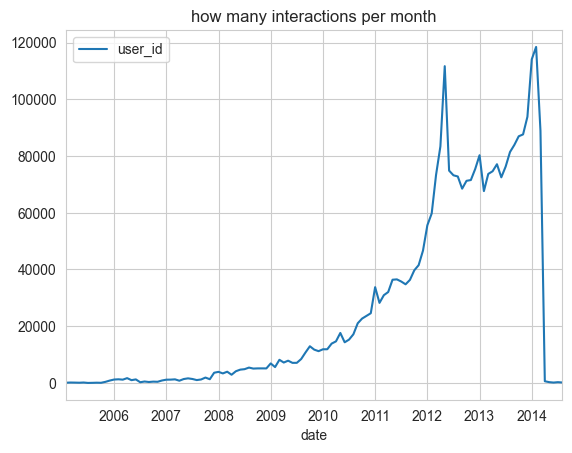

In [34]:
# # period=['2011-01', '2014-06']
# period=['0001-01', '9999-06']
# # sample = 'sample_'+str(period[0])+'_until_'+str(period[1])

# _, _, _, _  = load_interactions_within_period_to_dict(head=3000000,#None,
#                                                         period=period,# ['2012-07', '2015-01'[ 
#                                                         save_folder=None, 
#                                                         save_filename=None,
#                                                         file_foldername=dataset_folderpath+'lfm1b-tracks/lfm1b-tracks.inter')

# 2011-07 to 2014-01 3M

In [ ]:
# # period=['2011-01', '2014-06']
# period=['2011-07', '2014-01']
# sample = 'sample_'+str(period[0])+'_until_'+str(period[1])

# save_folder=output_path+sample+'/'
# filename = 'tracks_inter_merged_coldstart_3M'

# inter_df, _, user_set, item_set  = load_interactions_within_period_to_dict(head=3000000,#None,
#                                                                         period=period,
#                                                                         save_folder=save_folder, 
#                                                                         save_filename=filename,
#                                                                         file_foldername=dataset_folderpath+'lfm1b-tracks/lfm1b-tracks.inter')

In [14]:
# inter_df.date.max()

Timestamp('2014-01-01 00:00:00')

# get_interactions_info

In [ ]:
# user_presence_df, user_month_interactions, \
#     trimestres, user_trimestre_interactions, \
#         semesters, user_semester_interactions = get_interactions_info(inter_df, user_col, quarter_info=True, semester_info=True)

0.0 %
25.0 %
50.0 %
75.0 %


In [ ]:
# joblib.dump(user_presence_df, save_folder+filename+'_user_presence_df.joblib')
# joblib.dump(user_month_interactions, save_folder+filename+'_user_month_interactions.joblib')
# joblib.dump(trimestres, save_folder+filename+'_trimestres.joblib')
# joblib.dump(user_trimestre_interactions, save_folder+filename+'_user_trimestre_interactions.joblib')
# joblib.dump(semesters, save_folder+filename+'_semesters.joblib')
# joblib.dump(user_semester_interactions, save_folder+filename+'_user_semester_interactions.joblib')

# thr=0.8

# frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
# joblib.dump(frequent_users, save_folder+filename+'_frequent_users_'+str(thr)+'.joblib') # has all 3 in one file

106 users of 1112 (9.532%) occurr in 80.0% or more months.
343 users of 1112 (30.845%) occurr in 80.0% or more quarters.
510 users of 1112 (45.863%) occurr in 80.0% or more semesters.


['output/lastfm1b_dump/sample_2011-07_until_2014-01/tracks_inter_merged_coldstart_3M_frequent_users_0.8.joblib']

In [ ]:
# user_semester_interactions

,0,1,2,3,4,5
15397460,6.0,6.0,6.0,3.0,4.0,1.0
5651735,5.0,6.0,5.0,6.0,4.0,1.0
11819149,6.0,6.0,6.0,5.0,0.0,0.0
21158109,3.0,6.0,5.0,4.0,1.0,1.0
13986001,3.0,3.0,1.0,2.0,1.0,0.0
...,...,...,...,...,...,...
27660103,0.0,0.0,0.0,0.0,1.0,1.0
19450665,0.0,0.0,0.0,0.0,1.0,1.0
4142595,0.0,0.0,0.0,0.0,0.0,1.0
20943039,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
# semesters_idx=[1,2,3,4]
# n_semester_thr=3
# frequent_users_1213_semester_interactions = get_semester_info_with_user_thresh(print_timeperiod='2012 and 2013',
#                                                                                   usi=user_semester_interactions,
#                                                                                   semesters_idx=semesters_idx,
#                                                                                   n_semester_thr=n_semester_thr)

# frequent_users_1213_semester_interactions

856 users of 1112 (76.97841726618705%) are in 60.0% or more semesters in 2012 and 2013 (13205.0 interactions)

Number of interactions per semester in 2012 and 2013:
 1    3017.0
2    3263.0
3    3308.0
4    3067.0
5     550.0
dtype: float64


,1,2,3,4,5
15397460,6.0,6.0,3.0,4.0,1.0
5651735,6.0,5.0,6.0,4.0,1.0
11819149,6.0,6.0,5.0,0.0,0.0
21158109,6.0,5.0,4.0,1.0,1.0
13986001,3.0,1.0,2.0,1.0,0.0
...,...,...,...,...,...
14013708,0.0,0.0,1.0,6.0,1.0
33816422,0.0,0.0,1.0,5.0,1.0
20803227,0.0,0.0,1.0,6.0,1.0
7405199,0.0,0.0,1.0,6.0,1.0


3k isnt good...

# 2011-07 to 2014-01 11M

5M or 8M wasnt enough inter per bucket

0,1000000,2000000,3000000,4000000,5000000,6000000,7000000,8000000,9000000,10000000,11000000,complete
done!
number of lines  7608520
number of books  2852453
number of users  3499


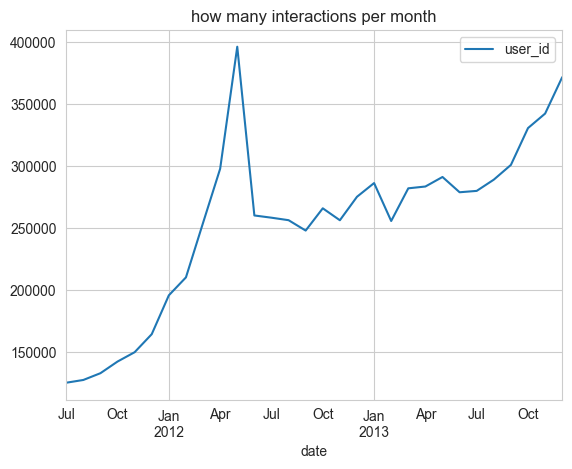

In [8]:
# period=['2011-01', '2014-06']
period=['2011-07', '2014-01']
sample = 'sample_'+str(period[0])+'_until_'+str(period[1])

save_folder=output_path+sample+'/'
filename = 'tracks_inter_merged_coldstart_11M' #5M, 8M

inter_df, _, user_set, item_set  = load_interactions_within_period_to_dict(head=11000000,#None,
                                                                        period=period,
                                                                        save_folder=save_folder, 
                                                                        save_filename=filename,
                                                                        file_foldername=dataset_folderpath+'lfm1b-tracks/lfm1b-tracks.inter')

In [10]:
inter_df.date.max()

Timestamp('2013-12-01 00:00:00')

In [11]:
user_presence_df, user_month_interactions, \
    trimestres, user_trimestre_interactions, \
        semesters, user_semester_interactions = get_interactions_info(inter_df, user_col, quarter_info=True, semester_info=True)

0.0 %


In [12]:
joblib.dump(user_presence_df, save_folder+filename+'_user_presence_df.joblib')
joblib.dump(user_month_interactions, save_folder+filename+'_user_month_interactions.joblib')
joblib.dump(trimestres, save_folder+filename+'_trimestres.joblib')
joblib.dump(user_trimestre_interactions, save_folder+filename+'_user_trimestre_interactions.joblib')
joblib.dump(semesters, save_folder+filename+'_semesters.joblib')
joblib.dump(user_semester_interactions, save_folder+filename+'_user_semester_interactions.joblib')

thr=0.8

frequent_users = get_frequent_users(user_presence_df, frequency_threshold=thr)
joblib.dump(frequent_users, save_folder+filename+'_frequent_users_'+str(thr)+'.joblib') # has all 3 in one file

578 users of 3499 (16.519%) occurr in 80.0% or more months.
1346 users of 3499 (38.468%) occurr in 80.0% or more quarters.
2068 users of 3499 (59.103%) occurr in 80.0% or more semesters.


['output/lastfm1b_dump/sample_2011-07_until_2014-01/tracks_inter_merged_coldstart_11M_frequent_users_0.8.joblib']

In [13]:
user_semester_interactions

,0,1,2,3,4
1000557,6.0,6.0,5.0,6.0,6.0
14975516,4.0,5.0,5.0,5.0,4.0
14972179,1.0,2.0,1.0,5.0,2.0
14914319,5.0,6.0,4.0,0.0,0.0
4931051,5.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
5086832,0.0,0.0,0.0,0.0,1.0
6068727,0.0,0.0,0.0,0.0,1.0
38190371,0.0,0.0,0.0,0.0,1.0
3624292,0.0,0.0,0.0,0.0,1.0


In [14]:
semesters_idx=[1,2,3,4]
n_semester_thr=3
frequent_users_1213_semester_interactions = get_semester_info_with_user_thresh(print_timeperiod='2012 and 2013',
                                                                                  usi=user_semester_interactions,
                                                                                  semesters_idx=semesters_idx,
                                                                                  n_semester_thr=n_semester_thr)

frequent_users_1213_semester_interactions

2477 users of 3499 (70.79165475850243%) are in 75.0% or more semesters in 2012 and 2013 (40239.0 interactions)

Number of interactions per semester in 2012 and 2013:
 1     9875.0
2    10969.0
3    10287.0
4     9108.0
dtype: float64


,1,2,3,4
1000557,6.0,5.0,6.0,6.0
14975516,5.0,5.0,5.0,4.0
14972179,2.0,1.0,5.0,2.0
4931051,1.0,1.0,0.0,1.0
14912953,6.0,6.0,6.0,6.0
...,...,...,...,...
11725379,0.0,1.0,6.0,5.0
27113317,0.0,1.0,6.0,6.0
6620888,0.0,1.0,4.0,1.0
49844951,0.0,1.0,6.0,6.0


In [15]:
frequent_users_1213 = frequent_users_1213_semester_interactions.index.to_list()
frequent_users_1213[:5]

['1000557', '14975516', '14972179', '4931051', '14912953']

In [16]:
# get frequent user interactions from the cold start bucket
f = user_semester_interactions.index.isin(frequent_users_1213)
cold_start_semester_interactions = user_semester_interactions.loc[f, 0]
cold_start_semester_interactions

1000557     6.0
14975516    4.0
14972179    1.0
4931051     5.0
14912953    6.0
           ... 
11725379    0.0
27113317    0.0
6620888     0.0
49844951    0.0
12830823    0.0
Name: 0, Length: 2477, dtype: float64

In [17]:
# add frequent user interactions from the cold start bucket to frame
frequent_users_1213_semester_interactions.insert(0, 0, cold_start_semester_interactions)
frequent_users_1213_semester_interactions

,0,1,2,3,4
1000557,6.0,6.0,5.0,6.0,6.0
14975516,4.0,5.0,5.0,5.0,4.0
14972179,1.0,2.0,1.0,5.0,2.0
4931051,5.0,1.0,1.0,0.0,1.0
14912953,6.0,6.0,6.0,6.0,6.0
...,...,...,...,...,...
11725379,0.0,0.0,1.0,6.0,5.0
27113317,0.0,0.0,1.0,6.0,6.0
6620888,0.0,0.0,1.0,4.0,1.0
49844951,0.0,0.0,1.0,6.0,6.0


In [18]:
# fu_1314_semesters = semesters # cold start + sample (it's the same bc the initial sample was already cold start + 2y)
# fu_1314_semesters

In [19]:
thr = n_semester_thr/len(semesters_idx) # 4 semesters -> 2 years 
sample_fu_1213 = 'fu_'+str(thr)

In [20]:
# joblib.dump(frequent_users_1213_semester_interactions, save_folder+filename+'_fu_'+str(n_semester_thr/len(semesters_idx))+'_user_semester_interactions.joblib')

# joblib.dump(fu_1314_semesters, output_path+filename+'_'+sample_fu_1213+'_semestres.joblib')
joblib.dump([None, None, frequent_users_1213], save_folder+filename+'_frequent_users_'+str(thr)+'.joblib')
joblib.dump(frequent_users_1213_semester_interactions, save_folder+filename+'_'+sample_fu_1213+'_user_semester_interactions.joblib')

['output/lastfm1b_dump/sample_2011-07_until_2014-01/tracks_inter_merged_coldstart_11M_fu_0.75_user_semester_interactions.joblib']

# meta

In [21]:
ex_item = pd.read_csv(dataset_folderpath+'lfm1b-tracks-example/lfm1b-tracks.item', delimiter='\t')#, header=None)
ex_item.head()

,tracks_id:token,name:token_seq,artists_id:token
0,1,A Matter of Time,3
1,2,Hangar 18,1
2,3,Up the Downstair,4
3,4,Mr. Carter (Featuring Jay-Z),2
4,5,Mixtaped,5


In [22]:
len(item_set)

2852453

In [26]:
item_set_ordered = sorted(item_set, key=int)

item_dict = {}
with open(dataset_folderpath+'lfm1b-tracks/lfm1b-tracks.item', 'r') as file:
    file.readline()
    for i, line in enumerate(file):
        line_array = re.split('\t|\n', line) # leave the last '\n' column to make sure the file is read properly

        if i % 100000 == 0:
            print(i, end=',')

        if len(item_set_ordered) % 10000 == 0:
            print('len='+str(len(item_set_ordered)), end=',')
  
        if (len(item_set_ordered)>0) and (line_array[0] in item_set_ordered):
            item_dict[i] = line_array[0:3]
            item_set_ordered.remove(line_array[0])
        elif len(item_set_ordered)==0:
            break
    print('complete!')

0,len=2850000,len=2840000,len=2830000,len=2820000,len=2810000,len=2800000,len=2790000,len=2780000,len=2770000,100000,len=2760000,len=2750000,len=2740000,

In [25]:
filename

'tracks_inter_merged_coldstart_11M'

In [ ]:
item_df = pd.DataFrame.from_dict(item_dict, orient='index',columns=['item_id', 'name', 'artist'])
item_df.to_csv(save_folder+'tracks_items_seen_meta'+'_df.csv')